# Using XGboost to Predict the the Victor a Boxing Bout and the Corresponding Method of Victory

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Libraries to visualize the model performance
import shap
import eli5
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Libraries to build a XGboost model
import xgboost
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline

/Users/minhphung/opt/anaconda3/envs/Sports/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Find and read dataset 
dataset = pd.read_csv('/Users/minhphung/Documents/Minh_Concordia/Fall_2022/STAT_497-Sports_Analytics/Final_Project/Final-Project/refined_matches.csv')

In [3]:
dataset['Specific_Method'].value_counts()

A_Decision    2900
A_Stoppage    2797
B_Decision     582
B_Stoppage     336
DRAW           278
win_A_DQ        54
win_B_DQ         8
Name: Specific_Method, dtype: int64

In [4]:
# Transform string class values to integers
lab_enc = LabelEncoder()
dataset['stance_A'] = lab_enc.fit_transform(dataset['stance_A'])
dataset['stance_B'] = lab_enc.fit_transform(dataset['stance_B'])

In [5]:
dataset.dtypes

Unnamed: 0           int64
age_A              float64
age_B              float64
height_A           float64
height_B           float64
reach_A            float64
reach_B            float64
stance_A             int64
stance_B             int64
weight_A           float64
weight_B           float64
won_A                int64
won_B                int64
lost_A               int64
lost_B               int64
drawn_A              int64
drawn_B              int64
kos_A                int64
kos_B              float64
won%_A             float64
won%_B             float64
KO%_A              float64
KO%_B              float64
Specific_Method     object
Height_Diff        float64
Reach_Diff         float64
dtype: object

## Splitting the dataset and apply the classification algorithm

In [6]:
#Inital selections and split dataset
Y = dataset['Specific_Method']
X = dataset.drop((['Specific_Method','Unnamed: 0']), axis=1)
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=99)


#Prt of the dataset that we will use as the features to train our dataset
features = X_train.columns
X_train = X_train[features]
X_valid = X_valid[features]

#Change the word values of our method of victories to integers so the model can understand
Y_train = lab_enc.fit_transform(Y_train)
Y_valid = lab_enc.transform(Y_valid)

#Create XGboost model
model = xgboost.XGBClassifier()

#Fit the model to our datasets
model.fit(X_train, Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', ...)

In [7]:
#See how effective our model was
Y_pred = model.predict(X_valid)
accuracy = accuracy_score(Y_valid, Y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 55.28%


## Time for visualization of the model's results and parameters

In [8]:
#See how important the features were for our model
eli5.show_weights(model, feature_names = X.columns.tolist())

Weight,Feature
0.0690,KO%_A
0.0480,won%_B
0.0472,KO%_B
0.0472,won%_A
0.0469,stance_A
0.0464,drawn_B
0.0451,weight_B
0.0444,drawn_A
0.0441,lost_A
0.0426,reach_B


In [9]:
#Initialize visualization
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid)
shap.initjs()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [10]:
model.classes_

array([0, 1, 2, 3, 4, 5, 6])

In [11]:
lab_enc.inverse_transform(model.classes_)

array(['A_Decision', 'A_Stoppage', 'B_Decision', 'B_Stoppage', 'DRAW',
       'win_A_DQ', 'win_B_DQ'], dtype=object)

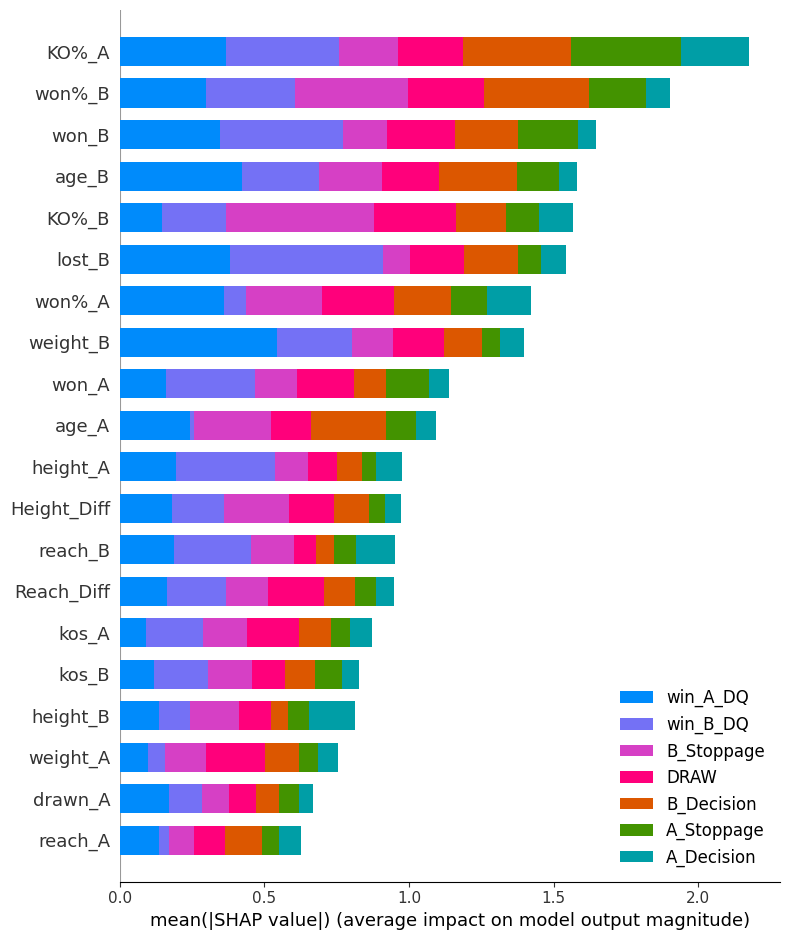

In [12]:
#Bar plot of most important features
shap.summary_plot(shap_values, X_valid, class_names = lab_enc.inverse_transform(model.classes_), plot_type="bar", show=False)
plt.savefig("summary_plot.png")

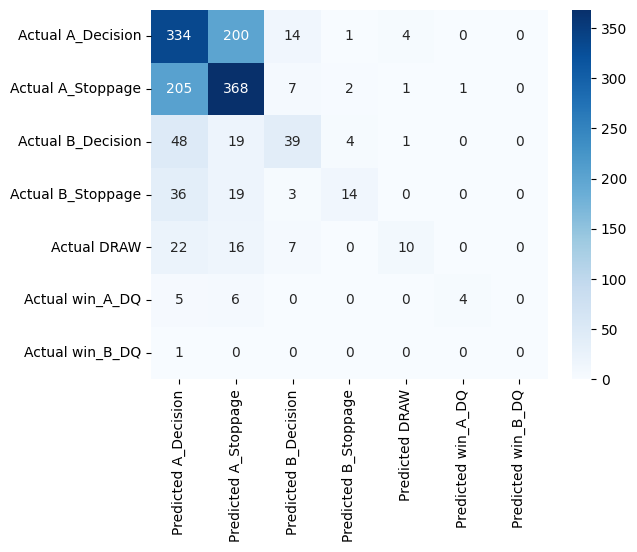

In [13]:
def plot_confusion_matrix(Y_valid, Y_pred):
  labels = lab_enc.inverse_transform([0, 1, 2, 3, 4, 5, 6])
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  df = pd.DataFrame(confusion_matrix(Y_valid, Y_pred),
                    columns = columns,
                    index = index)
  return sns.heatmap(df, annot=True, fmt='d', cmap='Blues')

plot_confusion_matrix(Y_valid, Y_pred);
plt.savefig("confusion.png")

In [14]:
len(Y_valid)

1391

## Focusing on the biggest parameter (won%_A)

In [15]:
#See why potentially KO%_A was one of the most used parameter
dataset['KO%_A'].corr(dataset['won%_A'])

0.6015698094826251

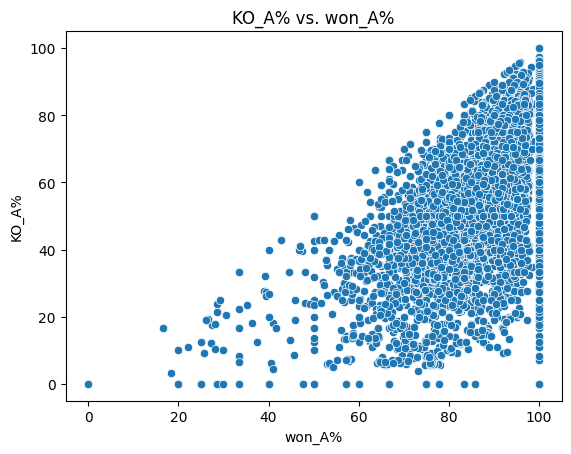

In [16]:
#Visualize the correlation above
ax = sns.scatterplot(x = "won%_A", y = "KO%_A", data = dataset)
ax.set_title("KO_A% vs. won_A%")
ax.set_xlabel("won_A%")
ax.set_ylabel("KO_A%");
plt.savefig("won%A_KO%A.png")

In [17]:
#See the correlation for just the absolute number of wins and KOs for A and 
dataset['won_A'].corr(dataset['kos_A'])

0.7689347113165236

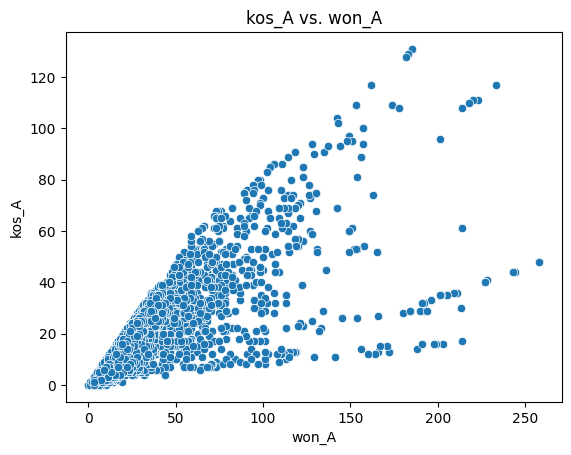

In [18]:
#Visualize the correlation above
ax = sns.scatterplot(x = "won_A", y = "kos_A", data = dataset)
ax.set_title("kos_A vs. won_A")
ax.set_xlabel("won_A")
ax.set_ylabel("kos_A");
plt.savefig("wonA_KOA.png")

In [19]:
#Do the same for B just to see if the relationship above still holds
dataset['KO%_B'].corr(dataset['won%_B'])

0.6834945542781591

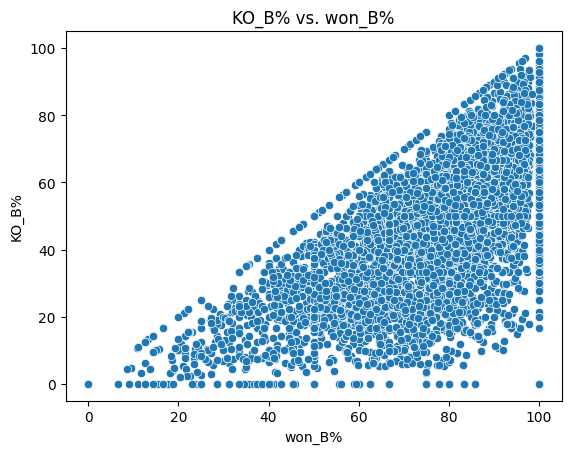

In [20]:
#Visualize the correlation above
ax = sns.scatterplot(x = "won%_B", y = "KO%_B", data = dataset)
ax.set_title("KO_B% vs. won_B%")
ax.set_xlabel("won_B%")
ax.set_ylabel("KO_B%");
plt.savefig("won%B_KO%B.png")

In [21]:
dataset['won_B'].corr(dataset['kos_B'])

0.8103513515787101

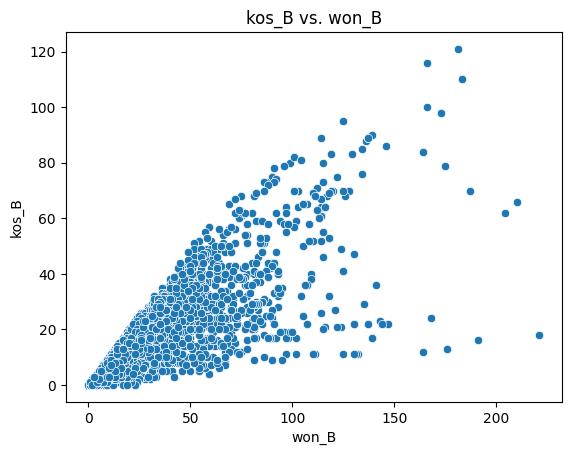

In [22]:
ax = sns.scatterplot(x = "won_B", y = "kos_B", data = dataset)
ax.set_title("kos_B vs. won_B")
ax.set_xlabel("won_B")
ax.set_ylabel("kos_B");
plt.savefig("wonB_KOB.png")

<AxesSubplot:title={'center':'Corellation between won% and KO% for B'}>

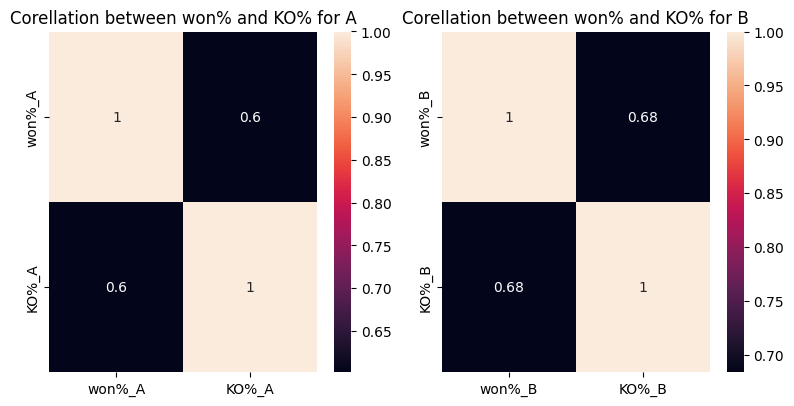

In [23]:
#Heatmap to organize all the correlations
fig, ax =plt.subplots(1,2,figsize=(8,4))
plt.tight_layout() 
ax[0].set_title('Corellation between won% and KO% for A')
ax[1].set_title('Corellation between won% and KO% for B')
sns.heatmap(dataset[['won%_A','KO%_A']].corr(),annot = True,ax = ax[0])
sns.heatmap(dataset[['won%_B','KO%_B']].corr(),annot = True,ax = ax[1])

<AxesSubplot:title={'center':'Corellation between won# and KO# for B'}>

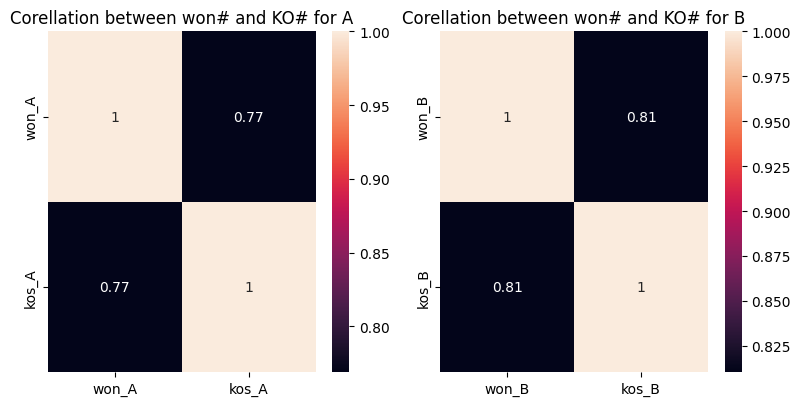

In [24]:
fig, ax =plt.subplots(1,2,figsize=(8,4))
plt.tight_layout() 
ax[0].set_title('Corellation between won# and KO# for A')
ax[1].set_title('Corellation between won# and KO# for B')
sns.heatmap(dataset[['won_A','kos_A']].corr(),annot = True,ax = ax[0])
sns.heatmap(dataset[['won_B','kos_B']].corr(),annot = True,ax = ax[1])